# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import shap

# Metrics
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report, confusion_matrix,
                             precision_recall_curve, auc, accuracy_score, f1_score)

# Load Data

In [2]:
link = "https://drive.google.com/file/d/1B__h7yRdqBTtozxfT60rrINQJyCp19MK/view"
path = "https://drive.google.com/uc?id=" + link.split("/")[-2]
df = pd.read_csv(path)

# Verify shapes
print("Data Shape:", df.shape)

Data Shape: (346, 10)


# Data Preview and Info

In [3]:
# Display few rows of dataset
print("Data Preview:")
display(df.head())

Data Preview:


,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.columns = (
    df.columns
    .str.strip()
)

# Display information about the DataFrames
print("\nTrain Data Info:")
df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    346 non-null    int64 
 1   Unnamed: 0      346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


## Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **dataset** contains 346 samples with 10 columns, including the target variable `loan_status`.

**Feature Overview**  
   - The datasets include all important attributes:  
     - **Numerical features:** `Principal`, `terms`, `age`
     - **Categorical features:** `education`, `Gender`.
   - The target variable is categorical.

**Data Completeness**  
   - The dataset have **no missing values**.
   - Data types are appropriate: numerical feature is int64 and categorical features is object.
   - The features `effective_date` and `due_date` need to convert date time.
   - The columns **Unnamed: 0.1** and **Unnamed: 0** need to remove.

## Feature Enginering

In [5]:
df["effective_date"] = pd.to_datetime(df["effective_date"], format = "mixed")
df["due_date"] = pd.to_datetime(df["due_date"], format = "mixed")

df["Weekday_effective_date"] = df["effective_date"].dt.day_name()
df["Weekday_due_date"] = df["due_date"].dt.day_name()
df["due_month"] = df["effective_date"].dt.month
df["effective_month"] = df["effective_date"].dt.month

def label_group_principal(row):
  if row["Principal"] <= 800:
    return "<= 800"
  else:
    return "<= 1000"

df["group_principal"] = df.apply(label_group_principal, axis=1)
df.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "effective_date", "due_date"], axis=1, inplace=True)

In [6]:
# Display information about the DataFrames
print("\nTrain Data Info:")
df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   loan_status             346 non-null    object
 1   Principal               346 non-null    int64 
 2   terms                   346 non-null    int64 
 3   age                     346 non-null    int64 
 4   education               346 non-null    object
 5   Gender                  346 non-null    object
 6   Weekday_effective_date  346 non-null    object
 7   Weekday_due_date        346 non-null    object
 8   due_month               346 non-null    int32 
 9   effective_month         346 non-null    int32 
 10  group_principal         346 non-null    object
dtypes: int32(2), int64(3), object(6)
memory usage: 27.2+ KB


In [7]:
cat_features = ["education", "Gender", "Weekday_effective_date", "Weekday_due_date", "group_principal", "due_month", "effective_month"]
target_feature = "loan_status"
def convert_cat(features, df = df):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
convert_cat(cat_features, df=df)

# Display information about the DataFrames
print("\nTrain Data Info:")
df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   loan_status             346 non-null    object  
 1   Principal               346 non-null    int64   
 2   terms                   346 non-null    int64   
 3   age                     346 non-null    int64   
 4   education               346 non-null    category
 5   Gender                  346 non-null    category
 6   Weekday_effective_date  346 non-null    category
 7   Weekday_due_date        346 non-null    category
 8   due_month               346 non-null    category
 9   effective_month         346 non-null    category
 10  group_principal         346 non-null    category
dtypes: category(7), int64(3), object(1)
memory usage: 14.6+ KB


In [8]:
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df.drop(columns=target_feature, axis=1).describe().T.style.background_gradient(cmap=cm))

Data describe:


,count,mean,std,min,25%,50%,75%,max
Principal,346.000000,943.641618,109.425530,300.000000,900.000000,1000.000000,1000.000000,1000.000000
terms,346.000000,22.653179,7.991006,7.000000,15.000000,30.000000,30.000000,30.000000
age,346.000000,30.939306,6.039418,18.000000,27.000000,30.000000,35.000000,51.000000


## Descriptive Insights – Numerical Features

* **Principal**: most loans are at **1000**, with only a few smaller amounts → highly skewed distribution.
* **Terms**: almost all customers choose **30**, very few select other values.
* **Age**: concentrated in the **27–35** range, customers are mostly young.

**Overall**: the data is quite **skewed in Principal & Terms**, while **Age** shows a more natural distribution.


In [9]:
num_features = ["terms", "age", "loan_status", "Principal"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df.drop(columns=num_features, axis=1).describe().T.style.background_gradient(cmap=cm, subset=["unique", "freq"]))

Data describe:


,count,unique,top,freq
education,346,4,High School or Below,151
Gender,346,2,male,294
Weekday_effective_date,346,7,Sunday,166
Weekday_due_date,346,7,Monday,135
due_month,346,1,9,346
effective_month,346,1,9,346
group_principal,346,2,<= 1000,260


## Descriptive Insights from Dataset Statistics

* **Education**: 4 groups, most common is **High School or Below** (151) → lower education level dominates.
* **Gender**: highly imbalanced, **male accounts for 294/346**.
* **Weekday\_effective\_date**: spread across 7 days, but **Sunday** is most frequent (166).
* **Weekday\_due\_date**: also across 7 days, but **Monday** stands out (135).
* **due\_month & effective\_month**: all records fall in **September**, no month-to-month variation. We need to remove.
* **group\_principal**: 2 groups, with **≤1000** being the majority (260).

 **Overall**: the data is skewed toward **male gender**, **lower education**, and **smaller loans (≤1000)**, while the month features carry little discriminative information.


In [10]:
df.drop(columns=["due_month", "effective_month"], axis = 1, inplace=True)

# Data Quality Checks

## Missing Value

In [11]:
def displayNULL(df, dataset_name=None):
    total_rows = len(df)

    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ["Feature", "Missing_Count"]
    missing_df = missing_df[missing_df["Missing_Count"] > 0]
    missing_df["Missing_%"] = (missing_df["Missing_Count"] / total_rows * 100).round(2)
    missing_df = missing_df.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)

    total_missing = missing_df["Missing_Count"].sum()

    print("=" * 40)
    if dataset_name:
        print(f"🔎 Missing Value Summary for: {dataset_name}")
    else:
        print("🔎 Missing Value Summary:")
    print("=" * 40)

    if total_missing == 0:
        print(f"✅ No missing values detected in {total_rows:,} rows.")
    else:
        try:
            from tabulate import tabulate
            print(tabulate(missing_df, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "left", "left")))
        except ImportError:
            print(missing_df.to_string(index=False))

        print(f"\n⚠️  Total missing values: {total_missing:,} out of {total_rows:,} rows.")

print("Missing value in the dataset: ")
displayNULL(df, dataset_name="Data Set")

Missing value in the dataset: 
🔎 Missing Value Summary for: Data Set
✅ No missing values detected in 346 rows.


## Duplicate Value

In [12]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)

    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)

    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
check_duplicates_report(df, "Data")
duplicate_summary["Data"] = {
    "duplicates": df.duplicated().sum(),
    "total_rows": len("Data")
}

🔍 Data Duplicate Analysis
⚠️  40 duplicates found (11.56%)
    Total rows affected: 40/346


In [13]:
df = df.drop_duplicates()
check_duplicates_report(df, "Data")
duplicate_summary["Data"] = {
    "duplicates": df.duplicated().sum(),
    "total_rows": len("Data")
}

🔍 Data Duplicate Analysis
✅ No duplicates found in 306 rows


## Checking Outlier Value

In [14]:
num_features = ["terms", "age", "Principal"]
def checking_outlier(list_feature, df, dataset_name):
    print("=" * 40)
    print(f"🔍 {dataset_name} Checking outlier")
    print("=" * 40)
    outlier_info = []
    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        if len(outliers) == 0:
            pass
        else:
            outlier_info.append({
            "Feature": feature,
            "Outlier Count": len(outliers),
            # "Outlier Detail": outliers.tolist()
            })
    return pd.DataFrame(outlier_info)

checking_outlier(list_feature=num_features, df=df, dataset_name="Training data")

🔍 Training data Checking outlier


,Feature,Outlier Count
0,age,4
1,Principal,3


## Data Quality Insights: Missing Values, Duplicates and Outliers

**Missing Values Analysis**

- We conducted a thorough check for missing values across the datasets.  
- **No missing values** in the datasets.

**Duplicate Records Analysis**

- We examined the datasets for duplicate rows that could bias the model.
- **The duplicate records** were found in dataset: 40 duplicates found (11.56%)
    Total rows affected: 40/346
-> We removed the duplicate records and re-check again to ensure no duplicate records exist in dataset.

**Outliers Records Analysis**

- We also examined the datasets for checking outliers.
- **The outliers** were found in dataset at features age and Principal. But we can not remove them since these outliers reflect reality and the numer of outliers is too small so we no need use Robust Scaler to scale data.

# Loan Status Distribution

In [15]:
def color(n_colors=2):
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    positions = np.linspace(0, 1, n_colors)
    colors = [cmap(p) for p in positions]
    return colors

/tmp/ipython-input-226874491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["loan_status"] = df["loan_status"].map({"PAIDOFF": 0, "COLLECTION": 1})


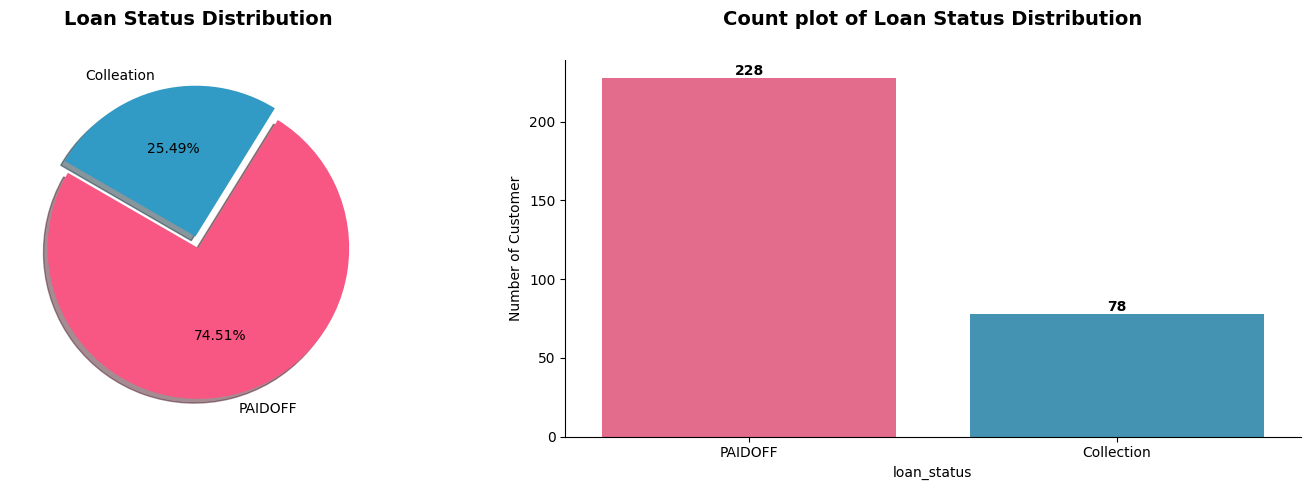

In [16]:
df["loan_status"] = df["loan_status"].map({"PAIDOFF": 0, "COLLECTION": 1})
loan_Distribution  = df["loan_status"].value_counts().loc[[0, 1]]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15, 5))
# ax[0]
ax[0].pie(
    loan_Distribution,
    labels = ["PAIDOFF", "Colleation"],
    colors = color(n_colors=2),
    autopct = "%1.2f%%",
    startangle = 150,
    explode = (0, 0.08),
    shadow= True
)
ax[0].set_title("Loan Status Distribution", weight="bold", fontsize=14, pad=25)

# ax[1]
sns.countplot(data=df, x = "loan_status", palette=color(n_colors=2), ax=ax[1], hue="loan_status")
ax[1].set_title("Count plot of Loan Status Distribution", weight="bold", fontsize=14, pad=25)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%d", label_type="edge", fontsize=10, weight="bold")
ax[1].set_ylabel("Number of Customer")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["PAIDOFF", "Collection"])
sns.despine(ax=ax[1], top=True, right=True, left=False, bottom=False)
ax[1].legend().remove()

plt.tight_layout()
plt.show()

* **PAIDOFF** is the majority (260 customers, \~75%) → most customers repay their loans on time.
* **Collection** is the minority (86 customers, \~25%) → a notable group still falls into debt collection.
* This imbalance ratio (\~3:1) should be considered when building classification models, as they may be biased toward predicting **PAIDOFF** unless handled properly (e.g., SMOTE, class\_weight, or using F1/ROC-AUC instead of accuracy).

**Overall**: The target variable is **imbalanced**, but the **Collection group is still large enough** for analysis and model training.


# Scale and Encode

In [17]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

print(X_train.shape, X_val.shape)

(244, 8) (62, 8)


In [18]:
# Currently, the features age and length_of_service contain outliers, so we will use RobustScaler to scale them in order to reduce the impact of these outliers.
num_stand_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # Handling Text and Categorical Attributes
])

In [19]:
num_features = ["terms", "age", "Principal"]
cat_features = ["education", "Gender", "Weekday_effective_date", "Weekday_due_date", "group_principal"]
preprocessor = ColumnTransformer(transformers=[
    ("num_robust", num_stand_transformer, num_features),
    ("cat_onehot", cat_onehot_transformer, cat_features)
])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_robust',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['terms', 'age', 'Principal']),
                                ('cat_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['education', 'Gender',
                                  'Weekday_effective_date', 'Weekday_due_date',
                                  'group_principal'])])

In [20]:
X_train_prepared = preprocessor.transform(X_train)
X_val_prepared = preprocessor.transform(X_val)
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num_robust__terms',
 'num_robust__age',
 'num_robust__Principal',
 'cat_onehot__education_Bechalor',
 'cat_onehot__education_High School or Below',
 'cat_onehot__education_Master or Above',
 'cat_onehot__education_college',
 'cat_onehot__Gender_female',
 'cat_onehot__Gender_male',
 'cat_onehot__Weekday_effective_date_Friday',
 'cat_onehot__Weekday_effective_date_Monday',
 'cat_onehot__Weekday_effective_date_Saturday',
 'cat_onehot__Weekday_effective_date_Sunday',
 'cat_onehot__Weekday_effective_date_Thursday',
 'cat_onehot__Weekday_effective_date_Tuesday',
 'cat_onehot__Weekday_effective_date_Wednesday',
 'cat_onehot__Weekday_due_date_Friday',
 'cat_onehot__Weekday_due_date_Monday',
 'cat_onehot__Weekday_due_date_Saturday',
 'cat_onehot__Weekday_due_date_Sunday',
 'cat_onehot__Weekday_due_date_Thursday',
 'cat_onehot__Weekday_due_date_Tuesday',
 'cat_onehot__Weekday_due_date_Wednesday',
 'cat_onehot__group_principal_<= 1000',
 'cat_onehot__group_principal_<= 800']

# Modeling

In [21]:
def plot_ROC_confusionMatrix(estimator, X_val, y_val, figsize=(12, 8)):
    RESET = "\033[0m"
    BLUE = "\033[94m"

    # Refer on Kaggel
    if estimator.__class__.__name__ == "SVC" and hasattr(estimator, "predict_proba"):
        y_pred_prob = estimator.predict_proba(X_val)[:, 1]
    elif estimator.__class__.__name__ in ["SVC", "LinearSVC", "RidgeClassifier"]:
        y_pred_prob = estimator.decision_function(X_val)
    else:
        y_pred_prob = estimator.predict_proba(X_val)[:, 1]

    y_pred = estimator.predict(X_val)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # --- Plot 1: ROC ---
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    rocScore = roc_auc_score(y_val, y_pred_prob)
    print(f"ROC AUC Score: {BLUE}{rocScore:.2f}{RESET}")
    print("-" * 80)

    f1_macro  = f1_score(y_val, y_pred, average="macro")
    print(f"F1 Macro Score: {BLUE}{f1_macro:.2f}{RESET}")
    print("-" * 80)

    f1_weighted  = f1_score(y_val, y_pred, average="weighted")
    print(f"F1 Weighted Score: {BLUE}{f1_weighted:.2f}{RESET}")
    print("-" * 80)

    ax[0, 0].plot(fpr, tpr, label=f"{estimator.__class__.__name__} (AUC = {rocScore:.2f})")
    ax[0, 0].plot([0, 1], [0, 1], "b--")
    ax[0, 0].set_xlabel("False Positive Rate")
    ax[0, 0].set_ylabel("True Positive Rate")
    ax[0, 0].set_title(f"ROC ({estimator.__class__.__name__})", fontsize=14, weight="bold", pad=20)
    ax[0, 0].legend()

    # --- Plot 2: Confusion Matrix ---
    confusionMatrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 1])
    ax[0, 1].set_title(f"Confusion Matrix ({estimator.__class__.__name__})", fontsize=14, weight="bold", pad=20)
    ax[0, 1].set_xlabel("Prediction")
    ax[0, 1].set_ylabel("Actual")

    # --- Plot 3: Precision-Recall Curve ---
    precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_prob)
    pr_auc = auc(recall, precision)
    print(f"PR AUC Score: {BLUE}{pr_auc:.2f}{RESET}")
    print("-" * 80)
    ax[1, 0].plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
    ax[1, 0].set_xlabel("Recall")
    ax[1, 0].set_ylabel("Precision")
    ax[1, 0].set_title("Precision-Recall Curve", fontsize=14, weight="bold", pad=20)
    ax[1, 0].legend()

    ax[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(classification_report(y_val, y_pred))

In [22]:
# Function to evaluate models
def evaluate_model(model, X_train, X_val, y_train, y_val, figsize = (15, 6)):
    print(f"Evaluating {model.__class__.__name__}...")
    model.fit(X_train, y_train)
    plot_ROC_confusionMatrix(estimator = model, X_val = X_val, y_val = y_val, figsize = figsize)

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_prepared, y_train)

print("After SMOTE:", pd.Series(y_train_res).value_counts())

After SMOTE: loan_status
0    182
1    182
Name: count, dtype: int64


## KNeighborsClassifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 17, 19, 21],
    "weights": ["uniform", "distance"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring="roc_auc",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)

grid_knn.fit(X_train_res, y_train_res)
print("Best params:", grid_knn.best_params_)
grid_knn.best_estimator_

Best params: {'n_neighbors': 5, 'weights': 'uniform'}


KNeighborsClassifier()

Evaluating KNeighborsClassifier...
ROC AUC Score: 0.68
--------------------------------------------------------------------------------
F1 Macro Score: 0.56
--------------------------------------------------------------------------------
F1 Weighted Score: 0.62
--------------------------------------------------------------------------------
PR AUC Score: 0.46
--------------------------------------------------------------------------------


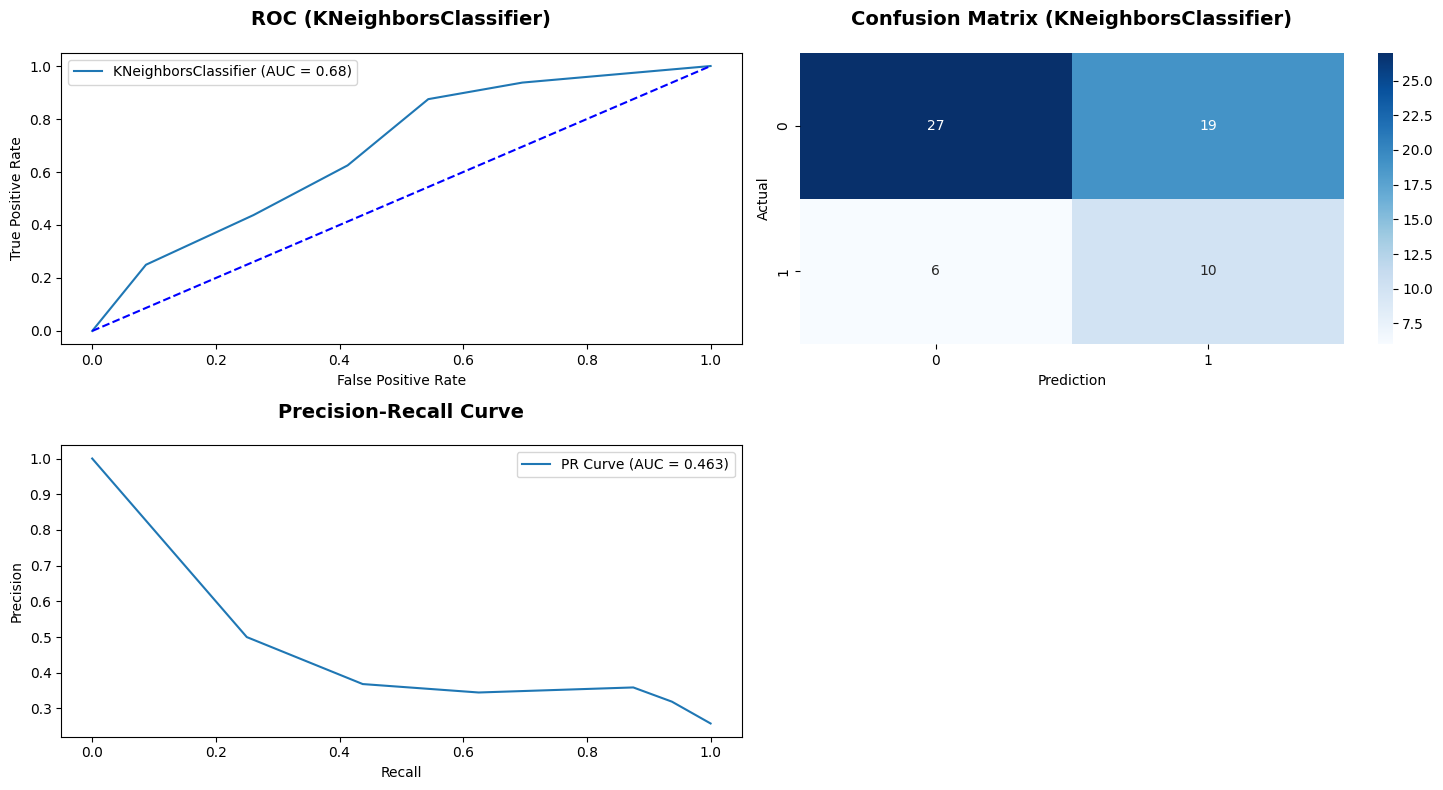

              precision    recall  f1-score   support

           0       0.82      0.59      0.68        46
           1       0.34      0.62      0.44        16

    accuracy                           0.60        62
   macro avg       0.58      0.61      0.56        62
weighted avg       0.70      0.60      0.62        62



In [25]:
evaluate_model(model = grid_knn.best_estimator_, X_train=X_train_res, X_val=X_val_prepared,
                               y_train=y_train_res, y_val=y_val, figsize=(15, 8))

## SVM

In [26]:
from sklearn.svm import SVC

param_grid = {
    "C": [0.1, 1, 2, 3, 10, 20, 30, 35, 40],
    "kernel": ["rbf", "linear"]
}

grid_svm = GridSearchCV(
    estimator=SVC(probability=False, max_iter=1000),
    param_grid=param_grid,
    scoring="roc_auc",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)

grid_svm.fit(X_train_res, y_train_res)
print("Best params:", grid_svm.best_params_)
grid_svm.best_estimator_

Best params: {'C': 3, 'kernel': 'rbf'}


SVC(C=3, max_iter=1000)

Evaluating SVC...
ROC AUC Score: 0.60
--------------------------------------------------------------------------------
F1 Macro Score: 0.59
--------------------------------------------------------------------------------
F1 Weighted Score: 0.66
--------------------------------------------------------------------------------
PR AUC Score: 0.31
--------------------------------------------------------------------------------


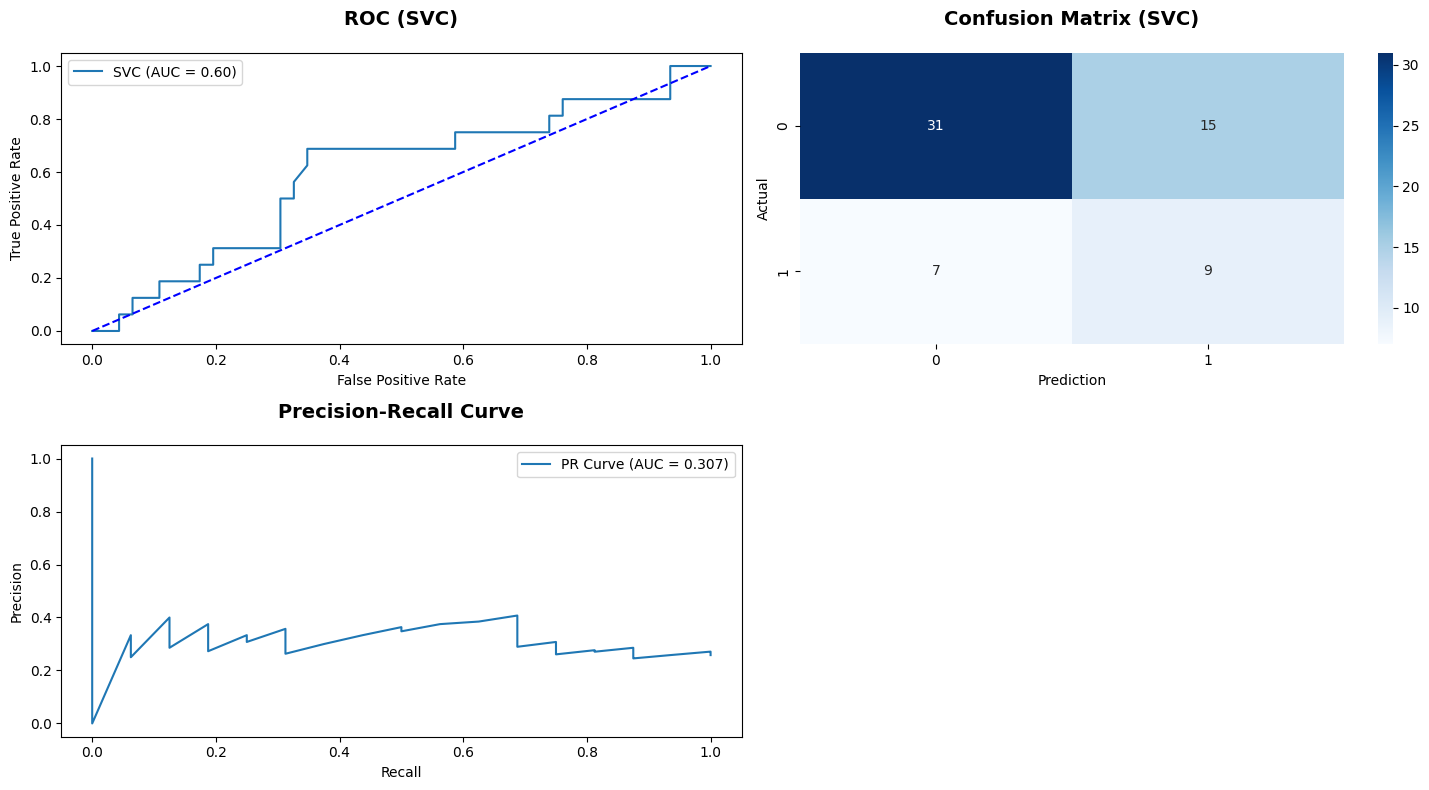

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        46
           1       0.38      0.56      0.45        16

    accuracy                           0.65        62
   macro avg       0.60      0.62      0.59        62
weighted avg       0.70      0.65      0.66        62



In [27]:
evaluate_model(model = grid_svm.best_estimator_, X_train=X_train_res, X_val=X_val_prepared,
                               y_train=y_train_res, y_val=y_val, figsize=(15, 8))

# Feature Impotance

## KNeighborsClassifier

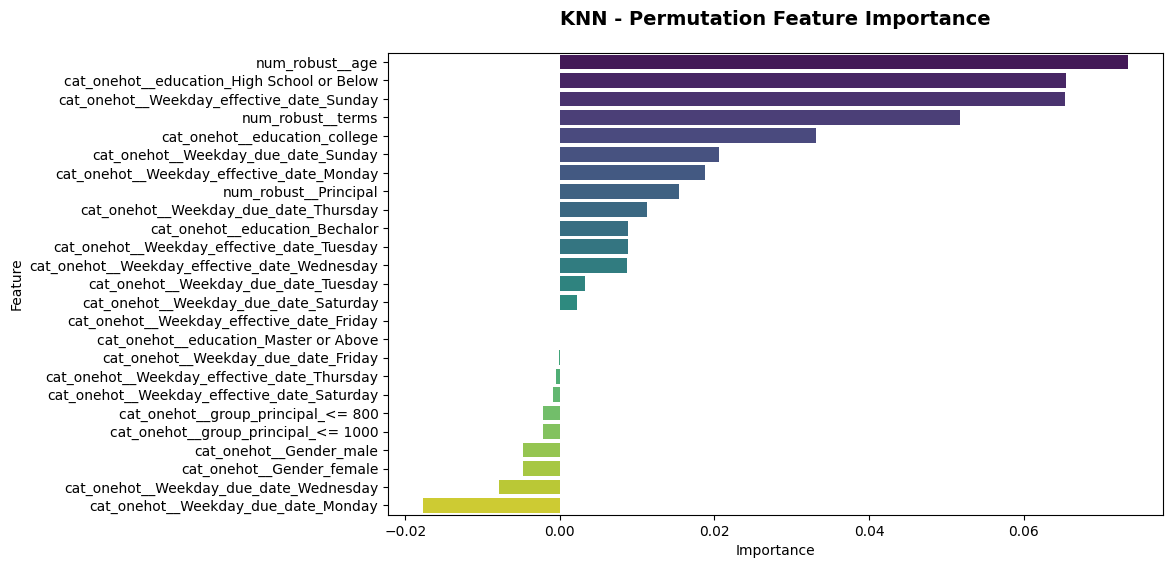

In [38]:
from sklearn.inspection import permutation_importance

knn_best = grid_knn.best_estimator_
knn_best.fit(X_train_res, y_train_res)

result = permutation_importance(
    knn_best, X_val_prepared, y_val, n_repeats=10, random_state=42, scoring="roc_auc"
)

importances = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("KNN - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()

## SVM

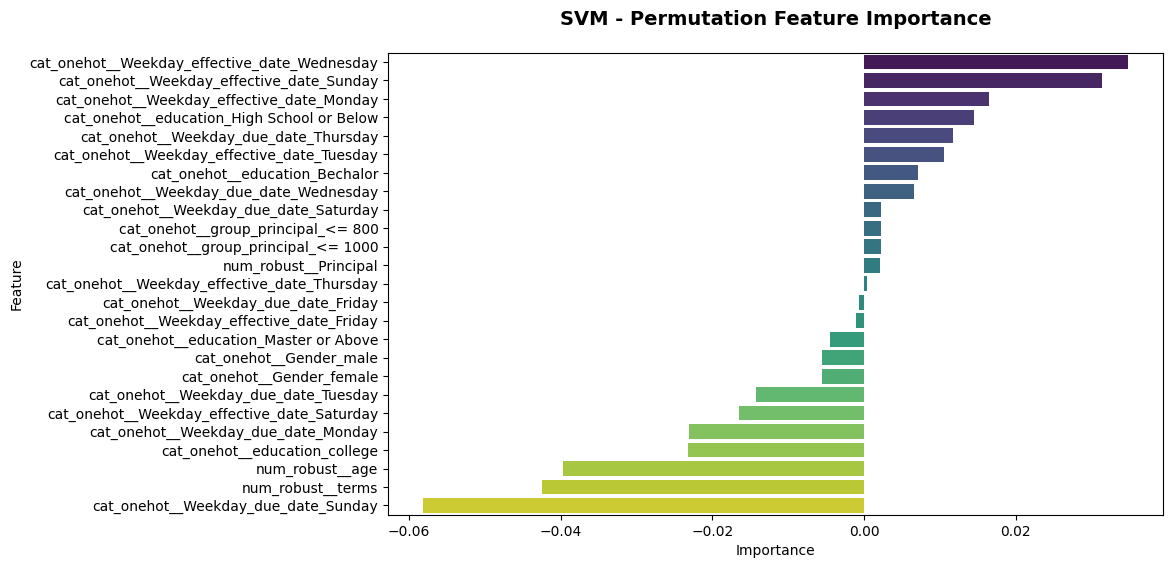

In [37]:
svm_best = grid_svm.best_estimator_
svm_best.fit(X_train_res, y_train_res)

result = permutation_importance(
    svm_best, X_val_prepared, y_val, n_repeats=10, random_state=42, scoring="roc_auc"
)

importances_svm = result.importances_mean

df_importances = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Importance": importances_svm
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis", hue = "Feature")
plt.title("SVM - Permutation Feature Importance", weight="bold", pad=20, fontsize=14)
plt.show()